In [1]:
%matplotlib inline

from GeoToolkit.Mag import Mag, ProblemSetter, MathUtils, Simulator, DataIO
from SimPEG.Utils import sdiag
import matplotlib.pyplot as plt
from GeoToolkit.graphics import graphics
import pyvista as pv
from pyvista import examples
import numpy as np
import scipy.sparse as sp
from skimage import exposure
pv.set_plot_theme('document')
pv.rcParams['use_panel'] = False

In [2]:
mesh = examples.download_topo_global()

# Compute the normals in-place and use them to warp the globe
mesh.compute_normals(inplace=True)  # this activates the normals as well


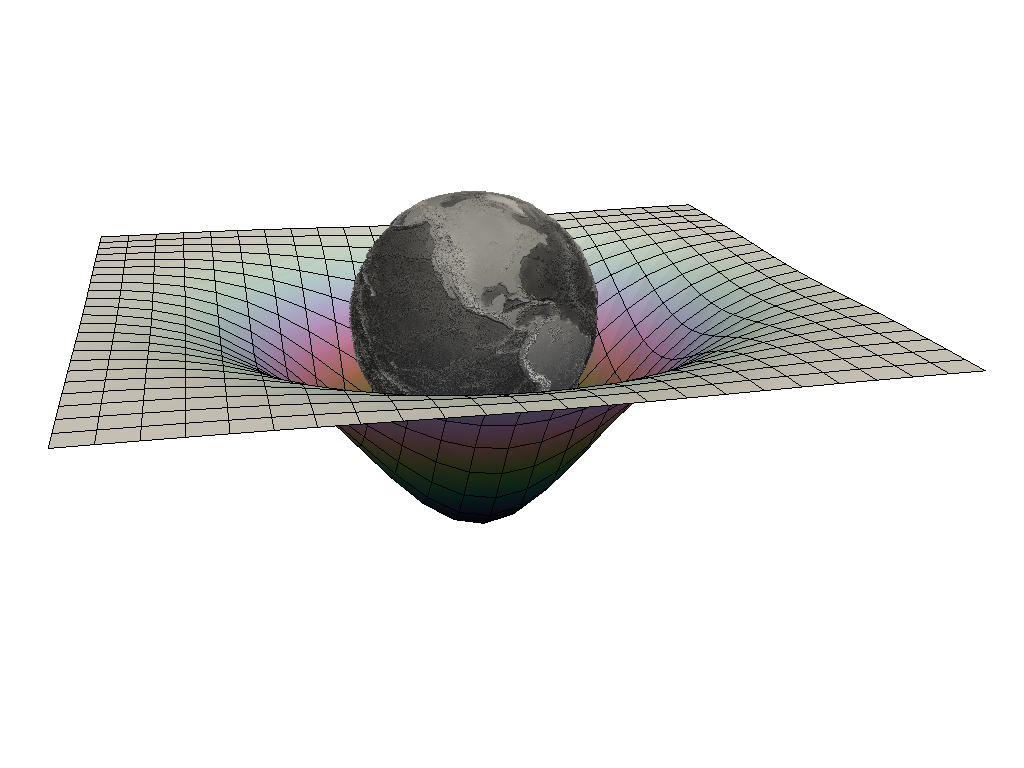

In [315]:

# Now use those normals to warp the surface
warp = mesh.warp_by_scalar(factor=0.5e-5)

# And let's see it!
# warp.plot(cmap="gist_earth", show_scalar_bar=False)
# phi = np.arange(-np.pi, np.pi, np.pi/4.)
# r = np.arange(0, 2, 0.1)
# R, P = np.meshgrid(phi,r)
x = np.arange(-3,3,0.25)
y = np.arange(-3,3,0.25)
x, y = np.meshgrid(x, y)
r = np.sqrt(x ** 2 + y ** 2)
z = -2*np.exp(-(x**2/2. + y**2/2.)) + 0.25

grid = pv.StructuredGrid(x, y, z)


plotter = pv.Plotter(notebook=True)
# pvgrid.texture_map_to_plane(inplace=True)
plotter.add_mesh(warp, cmap="gray", show_scalar_bar=False)
plotter.add_mesh(grid, scalars=z, show_edges=True, cmap='cubehelix')
plotter.show(cpos=[(-2.0487348823718854, -10.883231177766278, 3.0443253732868665),
 (0.2564741417062468, -0.21352678385572374, -0.5179043631255235),
 (0.07732948879425161, 0.3006608850748231, 0.9505909647944503)],screenshot="EarthGravity.png")

In [313]:

dipole = np.c_[np.cos(-np.pi/2.5), 0 ,np.sin(-np.pi/2.5)]

# Now use those normals to warp the surface
warp = mesh.warp_by_scalar(factor=0.5e-5)

# And let's see it!
# warp.plot(cmap="gist_earth", show_scalar_bar=False)
x = np.arange(-2.4,2.4,0.2)
z = np.arange(-1.6,1.6,0.2)
x, z = np.meshgrid(x, z)
y = 0*x
r = np.c_[x.flatten(order='F'), y.flatten(order='F'), z.flatten(order='F')]
m = np.kron(np.ones((r.shape[0],1)),  dipole)

r_unit = sdiag((np.sum(r**2., axis=1)+5e-1)**-0.5) * r

b =  sdiag((np.sum(r**2., axis=1)+5e-1)**-1.25 ) * (3*sdiag(np.sum(m  * r_unit, axis=1)) * r_unit - m) 
b[np.sum(r**2., axis=1)**0.5 < 1e-0,:] = np.nan

b_grid = b[:,2]




grid = pv.StructuredGrid(x, y, z)
grid.vectors = b/1.5





# geom = pv.Arrow()  # This could be any dataset

# Perform the glyph
# glyphs = grid.glyph(orient="vectors", factor=0.005, geom=geom)


r = mesh.points
r_unit = sdiag((np.sum(r**2., axis=1)+1e-1)**-0.5) * r
m = np.kron(np.ones((r.shape[0],1)),  dipole)
b = (3*sdiag(np.sum(m  * r_unit, axis=1)) * r_unit - m)
b_n = np.sum(b * mesh.point_normals, axis=1)



plotter = pv.Plotter(notebook=False)
# pvgrid.texture_map_to_plane(inplace=True)
plotter.add_mesh(warp, scalars=b_n, cmap="gray_r", show_scalar_bar=False)
plotter.add_mesh(grid, scalars=b_grid, show_edges=False, cmap='Spectral')
plotter.add_mesh(grid.arrows, scalars='GlyphScale', pivot='center', cmap='gray_r',show_scalar_bar=False)
plotter.show(cpos=[(-2.0487348823718854, -10.883231177766278, 3.0443253732868665),
 (0.2564741417062468, -0.21352678385572374, -0.5179043631255235),
 (0.07732948879425161, 0.3006608850748231, 0.9505909647944503)],screenshot="EarthMag.png")

[(-2.0487348823718854, -10.883231177766278, 3.0443253732868665),
 (0.2564741417062468, -0.21352678385572374, -0.5179043631255235),
 (0.07732948879425161, 0.3006608850748231, 0.9505909647944503)]

In [2]:
download = DataIO.fetchData(path=r"C:\Users\DominiqueFournier\Documents\GIT\GeoToolkit\Notebooks\Output", localCloud='Local')
display(download)

interactive(children=(RadioButtons(description='File Type:', options=('Local', 'Cloud'), value='Local'), Text(…

In [364]:
# DataIO.writeGeotiff(
#     np.flipud(aa), "WGM2012_FreeAir.tiff", gridObject.EPSGcode,
#     xmin, xmax, ymin, ymax,
#     1, dataType="grid"
# )


In [3]:
if download.result is not None:
    if (download.result[1] == "CSV")  :
        grid = Simulator.dataGriddingWidget(download.result[0], marker=False, dataColumn=3, Resolution=100, Method='linear')
        display(grid)
    else:
        grid = Simulator.dataGridGeoref(download.result[0])
        display(grid)

interactive(children=(Dropdown(description='ColorMap', index=3, options=('viridis', 'plasma', 'magma', 'Spectr…

In [4]:
if download.result is not None:
    selection = Simulator.setDataExtentWidget(grid.result)
    display(selection)

interactive(children=(FloatSlider(value=1.6167297726173707e-14, continuous_update=False, description='East', m…

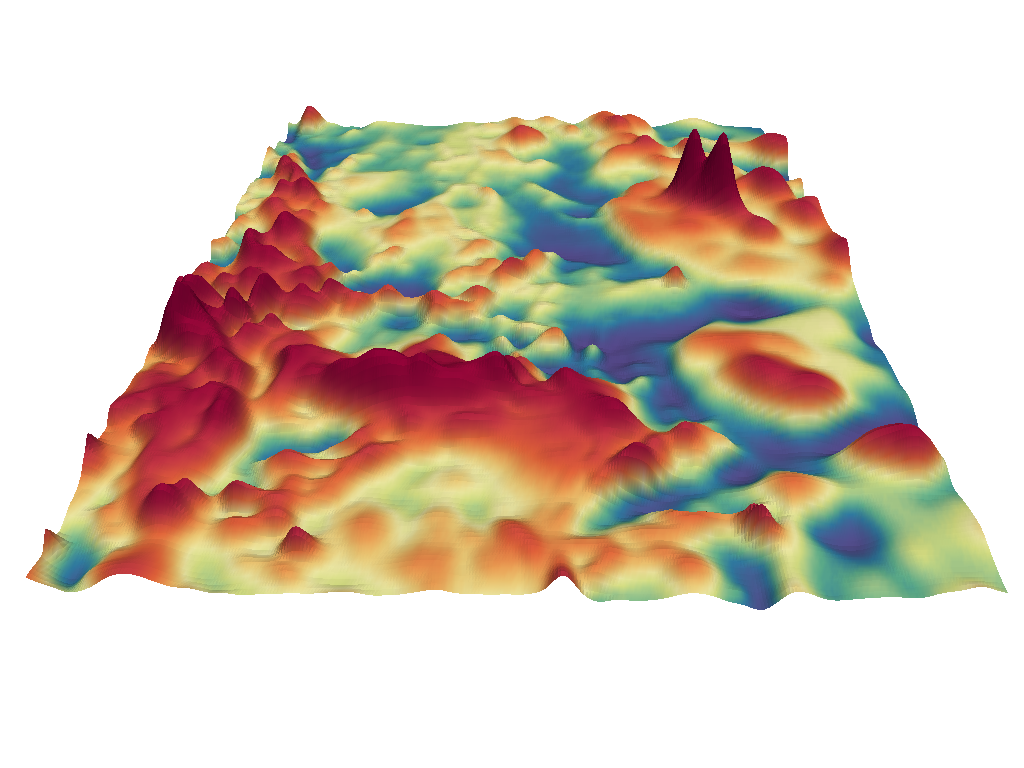

In [24]:
from matplotlib import cm
from skimage import exposure

values = (selection.result.values.copy())
indNan = np.isnan(values)
values[indNan] = 0

vmin, vmax = -4000, 8000

cdf, bins = exposure.cumulative_distribution(
        (values[(values < vmax) *
                       (values > vmin)]), nbins=256
)
cmap = graphics.equalizeColormap('Spectral_r', bins, cdf)
# rgb = cmap.to_rgba((((values.T)).flatten(order='F')))
# # cmap.set_clim(vmin=0, vmax=1000)


# rgb[indNan.reshape(-1),:] = np.nan

# texture = pv.numpy_to_texture(rgb[:,:3].reshape((values.shape[0], values.shape[1], 3), order='F'))


theta = (selection.result.gridCC[:, 0].reshape(values.shape, order='F'))
phi = (selection.result.gridCC[:, 1].reshape(values.shape, order='F'))


R = 5380
R = (R+(values)/20)
x = R * np.cos(np.deg2rad(phi)) * np.cos(np.deg2rad(theta))
y = R * np.cos(np.deg2rad(phi)) * np.sin(np.deg2rad(theta))
z = R * np.sin(np.deg2rad(phi))

# x = selection.result.gridCC[:, 0].reshape(values.shape, order='F')
# y = selection.result.gridCC[:, 1].reshape(values.shape, order='F')
# z = values/5

x[indNan] = np.nan
values[indNan] = np.nan
pvgrid = pv.StructuredGrid(
    x.T, 
    y.T, 
    z.T)
# grid.plot()
# grid.warp_by_scalar()
plotter = pv.Plotter(notebook=True)
# pvgrid.texture_map_to_plane(inplace=True)
plotter.add_mesh(pvgrid, scalars=values, cmap=cmap)

# plotter.export_vtkjs("EMAGv2_NorthAtlantic")
# plotter.show(auto_close=False)
# plotter.export_vtkjs("EMAGv2_NorthAtlantic")
# plotter.close()
# plotter.show(
#     cpos=[(5129.611755301267, 2157.873161782082, 5926.635574173455),
#  (2089.574112805277, -37.952885761104625, 4555.515700679695),
#  (-0.2767863524236539, -0.20325006175741522, 0.9391904639143307)], 
#     screenshot="EMAG90d.png")
# plotter.screenshot("EMAG90d.png")
lon = np.deg2rad(27)#np.deg2rad(15)
lat = np.deg2rad(67.7)#np.deg2rad(30)
r = 6000
xloc = r * np.cos(lat) * np.cos(lon)
yloc = r * np.cos(lat) * np.sin(lon)
zloc = r * np.sin(lat)

# plotter.show(cpos=[(xloc, yloc, zloc),
#  (0, 0, 500),
#  (-0., 0., 1)],screenshot="EMAG_m45d_NorthAmerica.png")
# Large view
# plotter.show(cpos=[(6053.18060192332, 1419.8421698073148, 6415.325176210674),
#  (2044.2806608584788, -10.673701877581124, 4612.252867030859),
#  (-0.3596642657094726, -0.15237282916552064, 0.9205564278759674)])

# Middle view
# plotter.show(cpos=[(3187.0998318049637, 2081.707503888414, 5001.011871672062),
#  (1848.549824736279, 751.5975240218856, 4727.89196482181),
#  (-0.05526397612824547, -0.14716860756088546, 0.9875663491082951)])


# Small view
# Read the GeoTIFF as a vtkTexture:


plotter.show(cpos=[(2481.6857948002835, 1275.3562368857397, 5078.085082348304),
 (1712.322032440504, 864.7372440254018, 4902.9769571772285),
 (-0.1761321093785013, -0.08808508776671177, 0.9804175117566039)],screenshot="EMAG_Kevitsa.png"
            )

# Cartesian Kevitsa plotter
# plotter.show( cpos=[(3503537.9917390947, 7495043.372086444, 11444.588074577092),
#  (3498073.9770745155, 7510717.605823356, 435.0068286203108),
#  (-0.06888187753633372, 0.5572240290585513, 0.8275002528016681)]
#             )

# Repeat for EWGM2012 (GRAV)

In [8]:
from matplotlib import cm
from skimage import exposure

values = (selection.result.values.copy())
indNan = np.isnan(values)
values[indNan] = 0

vmin, vmax = -200, 500

cdf, bins = exposure.cumulative_distribution(
        (values[(values < vmax) *
                       (values > vmin)]), nbins=256
)
cmap = graphics.equalizeColormap('Spectral_r', bins, cdf)
# rgb = cmap.to_rgba((((values.T)).flatten(order='F')))
# # cmap.set_clim(vmin=0, vmax=1000)


# rgb[indNan.reshape(-1),:] = np.nan

# texture = pv.numpy_to_texture(rgb[:,:3].reshape((values.shape[0], values.shape[1], 3), order='F'))


theta = (selection.result.gridCC[:, 0].reshape(values.shape, order='F'))
phi = (selection.result.gridCC[:, 1].reshape(values.shape, order='F'))


R = 5380
R = (R+(values)/5)
x = R * np.cos(np.deg2rad(phi)) * np.cos(np.deg2rad(theta))
y = R * np.cos(np.deg2rad(phi)) * np.sin(np.deg2rad(theta))
z = R * np.sin(np.deg2rad(phi))

# x = selection.result.gridCC[:, 0].reshape(values.shape, order='F')
# y = selection.result.gridCC[:, 1].reshape(values.shape, order='F')
# z = values/5

x[indNan] = np.nan
values[indNan] = np.nan
pvgrid = pv.StructuredGrid(
    x.T, 
    y.T, 
    z.T)
# grid.plot()
# grid.warp_by_scalar()
plotter = pv.Plotter(notebook=False)
# pvgrid.texture_map_to_plane(inplace=True)
plotter.add_mesh(pvgrid, scalars=values, cmap=cmap)

# plotter.export_vtkjs("EMAGv2_NorthAtlantic")
# plotter.show(auto_close=False)
# plotter.export_vtkjs("EMAGv2_NorthAtlantic")
# plotter.close()
# plotter.show(
#     cpos=[(5129.611755301267, 2157.873161782082, 5926.635574173455),
#  (2089.574112805277, -37.952885761104625, 4555.515700679695),
#  (-0.2767863524236539, -0.20325006175741522, 0.9391904639143307)], 
#     screenshot="EMAG90d.png")
# plotter.screenshot("EMAG90d.png")
lon = np.deg2rad(27)#np.deg2rad(15)
lat = np.deg2rad(67.7)#np.deg2rad(30)
r = 6000
xloc = r * np.cos(lat) * np.cos(lon)
yloc = r * np.cos(lat) * np.sin(lon)
zloc = r * np.sin(lat)

plotter.show(cpos=[(xloc, yloc, zloc),
 (0, 0, 500),
 (-0., 0., 1)],screenshot="EWGM2012_15d_Europe.png")
# Large view
# plotter.show(cpos=[(6053.18060192332, 1419.8421698073148, 6415.325176210674),
#  (2044.2806608584788, -10.673701877581124, 4612.252867030859),
#  (-0.3596642657094726, -0.15237282916552064, 0.9205564278759674)])

# Middle view
# plotter.show(cpos=[(3187.0998318049637, 2081.707503888414, 5001.011871672062),
#  (1848.549824736279, 751.5975240218856, 4727.89196482181),
#  (-0.05526397612824547, -0.14716860756088546, 0.9875663491082951)])


# Small view
# Read the GeoTIFF as a vtkTexture:


# plotter.show(cpos=[(2481.6857948002835, 1275.3562368857397, 5078.085082348304),
#  (1712.322032440504, 864.7372440254018, 4902.9769571772285),
#  (-0.1761321093785013, -0.08808508776671177, 0.9804175117566039)],screenshot="EWGM2012_Kevitsa.png")


# Cartesian Kevitsa plotter
# plotter.show( cpos=[(3503537.9917390947, 7495043.372086444, 11444.588074577092),
#  (3498073.9770745155, 7510717.605823356, 435.0068286203108),
#  (-0.06888187753633372, 0.5572240290585513, 0.8275002528016681)]
#             )

[(1231.4457588686, -454.90740190488145, 9441.284918312835),
 (-175.24263603459463, -1318.4813079291368, 327.81394328350405),
 (-0.8833888161359897, -0.43374442628583354, 0.17745414109517918)]

In [184]:
pv.get_vtkjs_url('https://www.dropbox.com/s/te1f2iqbjgzjt2m/EMAGv2_NorthAtlantic.vtkjs?dl=0')

'http://viewer.pyvista.org/?fileURL=https://dl.dropbox.com/s/te1f2iqbjgzjt2m/EMAGv2_NorthAtlantic.vtkjs?dl=0'

In [8]:
import gdal

filename = r"C:\Users\DominiqueFournier\Documents\GIT\GeoToolkit\Notebooks\Output\Kevitsa.tiff"

def get_gcps(filename):
    """This helper function retrieves the Ground Control 
    Points of a GeoTIFF. Note that this requires gdal"""
    get_point = lambda gcp : np.array([gcp.GCPX, gcp.GCPY, gcp.GCPZ])
    # Load a raster
    ds = gdal.Open(filename)
    # Grab the Groung Control Points
    points = np.array([get_point(gcp) for gcp in ds.GetGCPs()])
    # Now Grab the three corners of their bounding box
    #-- This guarantees we grab the right points
    bounds = pv.PolyData(points).bounds
    origin = [bounds[0], bounds[2], bounds[4]] # BOTTOM LEFT CORNER
    point_u = [bounds[1], bounds[2], bounds[4]] # BOTTOM RIGHT CORNER
    point_v = [bounds[0], bounds[3], bounds[4]] # TOP LEFT CORNER
    return origin, point_u, point_v

# Fetch the GCPs
origin, point_u, point_v = get_gcps(filename)

pvgrid = pv.StructuredGrid(
    x.T, 
    y.T, 
    z.T)

# Use the GCPs to map the texture coordiantes onto the topography surface
pvgrid.texture_map_to_plane(origin, point_u, point_v, inplace=True)

# Show GCPs in relation to topo surface with texture coordinates displayed
plotter = pv.Plotter(notebook=False)
# plotter.add_point_labels(np.array([origin, point_u, point_v,]), 
#                    ['Origin', 'Point U', 'Point V'],
#                    point_size=5, color='red')


texture = pv.read_texture(filename)

# Now plot the topo surface with the texture draped over it
# And make window size large for a high-res screenshot
plotter.add_mesh(pvgrid, texture=texture)

plotter.show(cpos=[(1834.711414761609, 935.8280249635918, 5122.345987268661),
 (1830.5536700530213, 925.2418172822629, 4974.846248806371),
 (0.0560924967961689, 0.9957498422121581, -0.07304713230260318)])


NameError: name 'x' is not defined

In [24]:
pvgrid.save("topo.vtk")

In [9]:


sphere = examples.load_globe()

p = pv.Plotter(notebook=False)
p.add_mesh(sphere, show_edges=False)
# p.camera_position = [-1, -1, 1]
p.show()


[(5496.779643544487, 1221.298825328085, 6165.074190752679),
 (2044.2806608584788, -10.673701877581124, 4612.252867030859),
 (-0.3596642657094726, -0.15237282916552064, 0.9205564278759674)]

poly([0.6 0.5])
poly([6.00000000e-01 5.00000000e-01 3.88008037e-16])
poly([ 6.00000000e-01  5.00000000e-01  6.46680061e-16 -2.41939336e-17])
poly([ 6.00000000e-01  5.00000000e-01 -3.23340031e-16  6.70007895e-16
  5.13975389e-16])
poly([ 6.00000000e-01  5.00000000e-01 -4.52676043e-16 -5.92805507e-16
  5.87400445e-16  5.27688743e-17])


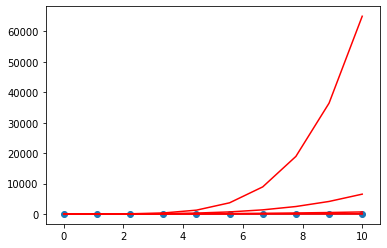

In [56]:
N = 10
x = np.linspace(0, 10, N)


# y = np.sin(x*4) * np.exp(-x)

true = 0.1
y = true*(1 + x)
# Add noise
y_noisy = y + np.random.randn(x.shape[0])/50


axs = plt.subplot()
axs.plot(x,y)

axs.scatter(x,y_noisy)
# Fit the data
for kk in range(5):
    param = np.polynomial.polynomial.Polynomial.fit(x, y, kk+1)
    model = np.polyval(param.coef, x)
    print(param)
    
    axs.plot(x,model, 'r')

    np.sum((model-true)**2.)**0.5/N

array([0.15, 0.05])